# Irradiance Download

In [ ]:
# Immporting Labriaries
# If not available, install using pip install <package-name>

# Import packages
import numpy as np
import pandas as pd
from scipy import interpolate
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import requests
import time
import os
import urllib3
import shutil
import plotly.graph_objs as go
import cmocean
import polars as pl
# Libraries for data handling

import polars as pl
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Library for estimating oceanographic parameters
import gsw

# Library for downloading data

import os
from pathlib import Path
import argopy
from argopy import DataFetcher

## Argopy bypass attempt

In [ ]:
root = '../data/argo'
profile_dir = root + '/Profiles/'

In [ ]:
# Function to download a single file
def download_file(url_path,filename,save_to=None,overwrite=False,verbose=True):
    """ Downloads and saves a file from a given URL using HTTP protocol.

    Note: If '404 file not found' error returned, function will return without downloading anything.
    
    Arguments:
        url_path: root URL to download from including trailing slash ('/')
        filename: filename to download including suffix
        save_to: None (to download to root Google Drive GO-BGC directory)
                 or directory path
        overwrite: False to leave existing files in place
                   or True to overwrite existing files
        verbose: True to announce progress
                 or False to stay silent
    
    """
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

    if save_to is None:
      save_to = root

    try:
      if filename in os.listdir(save_to):
          if not overwrite:
              if verbose: print('>>> File ' + filename + ' already exists. Leaving current version.')
              return
          else:
              if verbose: print('>>> File ' + filename + ' already exists. Overwriting with new version.')

      def get_func(url,stream=True):
          try:
              return requests.get(url,stream=stream,auth=None,verify=False)
          except requests.exceptions.ConnectionError as error_tag:
              print('Error connecting:',error_tag)
              time.sleep(1)
              return get_func(url,stream=stream)

      response = get_func(url_path + filename,stream=True)

      if response.status_code == 404:
          if verbose: print('>>> File ' + filename + ' returned 404 error during download.')
          return
      with open(save_to + filename,'wb') as out_file:
          shutil.copyfileobj(response.raw,out_file)
      del response
      if verbose: print('>>> Successfully downloaded ' + filename + '.')

    except:
      if verbose: print('>>> An error occurred while trying to download ' + filename + '.')

In [ ]:
# Function to download and parse GDAC synthetic profile index file
def argo_gdac(lat_range=None,lon_range=None,start_date=None,end_date=None,sensors=None,floats=None,
              overwrite_index=False,overwrite_profiles=False,skip_download=False,
              download_individual_profs=False,save_to=None,verbose=True):
  """ Downloads GDAC Sprof index file, then selects float profiles based on criteria.
      Either returns information on profiles and floats (if skip_download=True) or downloads them (if False).

      Arguments:
          lat_range: None, to select all latitudes
                     or [lower, upper] within -90 to 90 (selection is inclusive)
          lon_range: None, to select all longitudes
                     or [lower, upper] within either -180 to 180 or 0 to 360 (selection is inclusive)
                     NOTE: longitude range is allowed to cross -180/180 or 0/360
          start_date: None or datetime object
          end_date:   None or datetime object
          sensors: None, to select profiles with any combination of sensors
                   or string or list of strings to specify required sensors
                   > note that common options include PRES, TEMP, PSAL, DOXY, CHLA, BBP700,
                                                      PH_IN_SITU_TOTAL, and NITRATE
          floats: None, to select any floats matching other criteria
                  or int or list of ints specifying floats' WMOID numbers
          overwrite_index: False to keep existing downloaded GDAC index file, or True to download new index
          overwrite_profiles: False to keep existing downloaded profile files, or True to download new files
          skip_download: True to skip download and return: (<list of WMOIDs>, <DataFrame of index file subset>,
                                                            <list of downloaded filenames [if applicable]>)
                         or False to download those profiles
          download_individual_profs: False to download single Sprof file containing all profiles for each float
                                     or True to download individual profile files for each float
          save_to: None to download to Google Drive "/GO-BGC Workshop/Profiles" directory
                   or string to specify directory path for profile downloads
          verbose: True to announce progress, or False to stay silent

  """
  # Paths
  url_root = 'https://www.usgodae.org/ftp/outgoing/argo/'
  dac_url_root = url_root + 'dac/'
  index_filename = 'argo_synthetic-profile_index.txt'
  if save_to is None: save_to = root

  # Download GDAC synthetic profile index file
  download_file(url_root,index_filename,overwrite=overwrite_index)

  # Load index file into Pandas DataFrame
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],
                          date_parser=lambda x: pd.to_datetime(x,format='%Y%m%d%H%M%S'))

  # Establish time and space criteria
  if lat_range is None:  lat_range = [-90.0,90.0]
  if lon_range is None:  lon_range = [-180.0,180.0]
  elif lon_range[0] > 180 or lon_range[1] > 180:
    if lon_range[0] > 180: lon_range[0] -= 360
    if lon_range[1] > 180: lon_range[1] -= 360
  if start_date is None: start_date = datetime(1900,1,1)
  if end_date is None:   end_date = datetime(2200,1,1)

  float_wmoid_regexp = r'[a-z]*/[0-9]*/profiles/[A-Z]*([0-9]*)_[0-9]*[A-Z]*.nc'
  gdac_index['wmoid'] = gdac_index['file'].str.extract(float_wmoid_regexp).astype(int)
  filepath_main_regexp = '([a-z]*/[0-9]*/)profiles/[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath_main'] = gdac_index['file'].str.extract(filepath_main_regexp)
  filepath_regexp = '([a-z]*/[0-9]*/profiles/)[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath'] = gdac_index['file'].str.extract(filepath_regexp)
  filename_regexp = '[a-z]*/[0-9]*/profiles/([A-Z]*[0-9]*_[0-9]*[A-Z]*.nc)'
  gdac_index['filename'] = gdac_index['file'].str.extract(filename_regexp)

  # Subset profiles based on time and space criteria
  gdac_index_subset = gdac_index.loc[np.logical_and.reduce([gdac_index['latitude'] >= lat_range[0],
                                                            gdac_index['latitude'] <= lat_range[1],
                                                            gdac_index['date'] >= start_date,
                                                            gdac_index['date'] <= end_date]),:]
  if lon_range[1] >= lon_range[0]:    # range does not cross -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_and(gdac_index_subset['longitude'] >= lon_range[0],
                                                             gdac_index_subset['longitude'] <= lon_range[1])]
  elif lon_range[1] < lon_range[0]:   # range crosses -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_or(gdac_index_subset['longitude'] >= lon_range[0],
                                                            gdac_index_subset['longitude'] <= lon_range[1])]

  # If requested, subset profiles using float WMOID criteria
  if floats is not None:
    if type(floats) is not list: floats = [floats]
    gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['wmoid'].isin(floats),:]

  # If requested, subset profiles using sensor criteria
  if sensors is not None:
    if type(sensors) is not list: sensors = [sensors]
    for sensor in sensors:
      gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['parameters'].str.contains(sensor),:]

  # Examine subsetted profiles
  wmoids = gdac_index_subset['wmoid'].unique()
  wmoid_filepaths = gdac_index_subset['filepath_main'].unique()

  # Just return list of floats and DataFrame with subset of index file, or download each profile
  if not skip_download:
    downloaded_filenames = []
    if download_individual_profs:
      for p_idx in gdac_index_subset.index:
        download_file(dac_url_root + gdac_index_subset.loc[p_idx]['filepath'],
                      gdac_index_subset.loc[p_idx]['filename'],
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(gdac_index_subset.loc[p_idx]['filename'])
    else:
      for f_idx, wmoid_filepath in enumerate(wmoid_filepaths):
        download_file(dac_url_root + wmoid_filepath,str(wmoids[f_idx]) + '_Sprof.nc',
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(str(wmoids[f_idx]) + '_Sprof.nc')
    return wmoids, gdac_index_subset, downloaded_filenames
  else:
    return wmoids, gdac_index_subset

In [ ]:
wmoids, gdac_index, downloaded_filenames \
                   = argo_gdac(lat_range=[55,67],lon_range=[-44,-10],
                               start_date=None,end_date=None,
                               sensors=None,floats=None,
                               overwrite_index=False,overwrite_profiles=False,
                               skip_download=False,download_individual_profs=False,
                               save_to=profile_dir,verbose=True)

>>> Successfully downloaded argo_synthetic-profile_index.txt.


/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_5207/3441803214.py:44: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],


>>> Successfully downloaded 1902304_Sprof.nc.
>>> Successfully downloaded 3902258_Sprof.nc.
>>> Successfully downloaded 3902259_Sprof.nc.
>>> Successfully downloaded 3902260_Sprof.nc.
>>> Successfully downloaded 3902261_Sprof.nc.
>>> Successfully downloaded 3902333_Sprof.nc.
>>> Successfully downloaded 4903365_Sprof.nc.
>>> Successfully downloaded 4903488_Sprof.nc.
>>> Successfully downloaded 4903532_Sprof.nc.
>>> Successfully downloaded 3901581_Sprof.nc.
>>> Successfully downloaded 3901586_Sprof.nc.
>>> Successfully downloaded 3902681_Sprof.nc.
>>> Successfully downloaded 6901180_Sprof.nc.
>>> Successfully downloaded 6901933_Sprof.nc.
>>> Successfully downloaded 6904185_Sprof.nc.
>>> Successfully downloaded 1901209_Sprof.nc.
>>> Successfully downloaded 1901210_Sprof.nc.
>>> Successfully downloaded 1901211_Sprof.nc.
>>> Successfully downloaded 1901214_Sprof.nc.
>>> Successfully downloaded 1901215_Sprof.nc.
>>> Successfully downloaded 1901217_Sprof.nc.
>>> Successfully downloaded 190262

In [ ]:
# Load downloaded profiles into xarray Dataset
fn = sorted(Path(profile_dir).glob("*_Sprof.nc"))[0]
ds = xr.open_dataset(fn)

print("FILE:", fn.name)
print("\n--- DATASET SUMMARY ---")
print(ds)

print("\n--- DIMS ---")
print(ds.dims)

print("\n--- COORDS ---")
print(list(ds.coords))

print("\n--- DATA VARIABLES (first 50) ---")
print(list(ds.data_vars)[:50])

FILE: 1901209_Sprof.nc

--- DATASET SUMMARY ---
<xarray.Dataset> Size: 389kB
Dimensions:                       (N_PROF: 25, N_PARAM: 4, N_CALIB: 2,
                                   N_LEVELS: 121)
Dimensions without coordinates: N_PROF, N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/58)
    DATA_TYPE                     object 8B ...
    FORMAT_VERSION                object 8B ...
    HANDBOOK_VERSION              object 8B ...
    REFERENCE_DATE_TIME           object 8B ...
    DATE_CREATION                 object 8B ...
    DATE_UPDATE                   object 8B ...
    ...                            ...
    DOXY                          (N_PROF, N_LEVELS) float32 12kB ...
    DOXY_QC                       (N_PROF, N_LEVELS) object 24kB ...
    DOXY_dPRES                    (N_PROF, N_LEVELS) float32 12kB ...
    DOXY_ADJUSTED                 (N_PROF, N_LEVELS) float32 12kB ...
    DOXY_ADJUSTED_QC              (N_PROF, N_LEVELS) object 24kB ...
    DOXY_ADJUSTED_ERROR           (N

In [ ]:
from pathlib import Path
import numpy as np
import xarray as xr
import polars as pl

in_dir = Path(profile_dir)
out_parquet = in_dir / "argo_sprof_flat.parquet"

# --- helpers -------------------------------------------------

def _as_str1(x):
    """Convert xarray object/bytes scalars to python str (safe)."""
    if x is None:
        return None
    if hasattr(x, "dtype") and x.dtype.kind in ("S", "U", "O"):
        # x could be 0-d or array; we handle element-wise elsewhere
        pass
    if isinstance(x, (bytes, np.bytes_)):
        return x.decode("utf-8", errors="ignore").strip()
    return str(x).strip()

def _obj_array_to_utf8(a: np.ndarray) -> np.ndarray:
    """Convert object/bytes array to str array; keep None for missing."""
    out = np.empty(a.shape, dtype=object)
    it = np.nditer(a, flags=["multi_index", "refs_ok"], op_flags=["readonly"])
    for v in it:
        vv = v.item()
        if vv is None:
            out[it.multi_index] = None
        elif isinstance(vv, (bytes, np.bytes_)):
            out[it.multi_index] = vv.decode("utf-8", errors="ignore").strip()
        else:
            out[it.multi_index] = str(vv).strip()
    return out

def _get_1d(ds, name, nprof):
    """Return 1D array (N_PROF,) for variable name, or None."""
    if name not in ds:
        return None
    v = ds[name].values
    # Many profile vars are (N_PROF,) already
    if v.ndim == 1 and v.shape[0] == nprof:
        if v.dtype == object:
            v = _obj_array_to_utf8(v)
        return v
    # Some are (N_PROF, something) like JULD_LOCATION; ignore by default
    return None

def _get_2d(ds, name, nprof, nlev):
    """Return 2D array (N_PROF,N_LEVELS) for variable name, or None."""
    if name not in ds:
        return None
    v = ds[name].values
    if v.ndim == 2 and v.shape == (nprof, nlev):
        if v.dtype == object:
            v = _obj_array_to_utf8(v)
        return v
    return None

# Choose what to include:
PROFILE_VARS = [
    "PLATFORM_NUMBER", "CYCLE_NUMBER", "DIRECTION",
    "JULD", "LATITUDE", "LONGITUDE",
    "POSITION_QC", "JULD_QC", "CHLA", "CHLA_ADJUSTED",
    "CHLA_QC", "CHLA_ADJUSTED_QC",
    "DOWNWELLING_PAR", "DOWNWELLING_PAR_ADJUSTED",
    "DOWNWELLING_PAR_QC", "DOWNWELLING_PAR_ADJUSTED_QC", "TIME"
]
# Include all 2D measurement vars automatically except obvious metadata
EXCLUDE_2D_PREFIX = {
    "SCIENTIFIC_CALIB_", "PROFILE_", "STATION_PARAMETERS", "PARAMETER",
}
EXCLUDE_EXACT = {
    "DATA_TYPE","FORMAT_VERSION","HANDBOOK_VERSION","REFERENCE_DATE_TIME",
    "DATE_CREATION","DATE_UPDATE","PROJECT_NAME","PI_NAME","DATA_CENTRE",
    "PLATFORM_TYPE","FLOAT_SERIAL_NO","FIRMWARE_VERSION","WMO_INST_TYPE",
    "PARAMETER_DATA_MODE","CONFIG_MISSION_NUMBER","POSITIONING_SYSTEM",
    "JULD_LOCATION",  
}

def flatten_one_file(nc_path: Path) -> pl.DataFrame:
    ds = xr.open_dataset(nc_path, decode_cf=True)

    nprof = int(ds.dims["N_PROF"])
    nlev  = int(ds.dims["N_LEVELS"])

    # Level & profile indices for joins/debugging
    prof_idx = np.repeat(np.arange(nprof, dtype=np.int32), nlev)
    lev_idx  = np.tile(np.arange(nlev, dtype=np.int32), nprof)

    cols = {
        "source_file": np.repeat(nc_path.name, nprof * nlev),
        "prof_index": prof_idx,
        "level_index": lev_idx,
    }

    # Profile vars repeated to levels
    for vname in PROFILE_VARS:
        v = _get_1d(ds, vname, nprof)
        if v is not None:
            cols[vname] = np.repeat(v, nlev)

    # All 2D measurement vars
    for vname in list(ds.data_vars):
        if vname in cols or vname in EXCLUDE_EXACT:
            continue
        if any(vname.startswith(pfx) for pfx in EXCLUDE_2D_PREFIX):
            continue
        v2 = _get_2d(ds, vname, nprof, nlev)
        if v2 is None:
            continue
        cols[vname] = v2.reshape(-1)

    ds.close()

    # Build Polars DF
    df = pl.DataFrame(cols)

    # Optional: cast QC columns to categorical (saves space)
    #qc_cols = [c for c in df.columns if c.endswith("_QC") or c in ("POSITION_QC","JULD_QC")]
    #if qc_cols:
    #    df = df.with_columns([pl.col(c).cast(pl.Categorical) for c in qc_cols if c in df.columns])

    ## Optional: cast PLATFORM_NUMBER, DIRECTION to categorical
    #for c in ["PLATFORM_NUMBER","DIRECTION"]:
    #    if c in df.columns:
    #        df = df.with_columns(pl.col(c).cast(pl.Categorical))

    return df

# --- main: stream-write into ONE parquet ----------------------

files = sorted(in_dir.glob("*_Sprof.nc"))
if not files:
    raise FileNotFoundError(f"No *_Sprof.nc found in {in_dir}")

# Use a sink (streaming) so you don’t hold everything in memory
lazy_frames = [flatten_one_file(f).lazy() for f in files]
big = pl.concat(lazy_frames, how="diagonal_relaxed")

# Write one parquet file
big.sink_parquet(out_parquet, compression="zstd")
print("Wrote:", out_parquet)

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_12566/3863055634.py:84: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nprof = int(ds.dims["N_PROF"])
/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_12566/3863055634.py:85: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nlev  = int(ds.dims["N_LEVELS"])
/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_12566/3863055634.py:84: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from d

Wrote: ../data/argo/Profiles/argo_sprof_flat.parquet


In [ ]:
df = pl.read_parquet("../data/argo/Profiles/argo_sprof_flat.parquet")

# convert categoricals to strings so pandas won't choke later
df = df.with_columns([
    pl.col(pl.Categorical).cast(pl.Utf8)
])

df.write_parquet("../data/argo/Profiles/argo_sprof_flat_pd.parquet")

## Downlading a couple of floats code

### Float 4903659

In [ ]:
wmoids, gdac_index, downloaded_filenames \
                   = argo_gdac(lat_range=None,lon_range=None,
                               start_date=None,end_date=None,
                               sensors=None,floats=4903659,
                               overwrite_index=False,overwrite_profiles=False,
                               skip_download=False,download_individual_profs=False,
                               save_to=profile_dir,verbose=True)

>>> Successfully downloaded argo_synthetic-profile_index.txt.


/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_5207/3441803214.py:44: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],


>>> File 4903659_Sprof.nc already exists. Leaving current version.


In [ ]:
# Downloading dataset and renaming profile number dimension

data = xr.open_dataset('../data/argo/Profiles/' + '4903659_Sprof.nc')
#data = data.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})
display(data)

print(data.dims)
print(list(data.data_vars))

<xarray.Dataset> Size: 48MB
Dimensions:                            (N_PROF: 68, N_PARAM: 15, N_CALIB: 1,
                                        N_LEVELS: 1486)
Dimensions without coordinates: N_PROF, N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/135)
    DATA_TYPE                          object 8B ...
    FORMAT_VERSION                     object 8B ...
    HANDBOOK_VERSION                   object 8B ...
    REFERENCE_DATE_TIME                object 8B ...
    DATE_CREATION                      object 8B ...
    DATE_UPDATE                        object 8B ...
    ...                                 ...
    BISULFIDE                          (N_PROF, N_LEVELS) float32 404kB ...
    BISULFIDE_QC                       (N_PROF, N_LEVELS) object 808kB ...
    BISULFIDE_dPRES                    (N_PROF, N_LEVELS) float32 404kB ...
    BISULFIDE_ADJUSTED                 (N_PROF, N_LEVELS) float32 404kB ...
    BISULFIDE_ADJUSTED_QC              (N_PROF, N_LEVELS) object 808kB ...
    BISULFIDE_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 404kB ...
Attributes:
    title:                Argo float vertical profile
    institution:          CORIOLIS
    source:               Argo float
    history:              2025-06-10T16:25:53Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.19 (version 12.05.2025 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182

FrozenMappingWarningOnValuesAccess({'N_PROF': 68, 'N_PARAM': 15, 'N_CALIB': 1, 'N_LEVELS': 1486})
['DATA_TYPE', 'FORMAT_VERSION', 'HANDBOOK_VERSION', 'REFERENCE_DATE_TIME', 'DATE_CREATION', 'DATE_UPDATE', 'PLATFORM_NUMBER', 'PROJECT_NAME', 'PI_NAME', 'STATION_PARAMETERS', 'CYCLE_NUMBER', 'DIRECTION', 'DATA_CENTRE', 'PARAMETER_DATA_MODE', 'PLATFORM_TYPE', 'FLOAT_SERIAL_NO', 'FIRMWARE_VERSION', 'WMO_INST_TYPE', 'JULD', 'JULD_QC', 'JULD_LOCATION', 'LATITUDE', 'LONGITUDE', 'POSITION_QC', 'POSITIONING_SYSTEM', 'CONFIG_MISSION_NUMBER', 'PARAMETER', 'SCIENTIFIC_CALIB_EQUATION', 'SCIENTIFIC_CALIB_COEFFICIENT', 'SCIENTIFIC_CALIB_COMMENT', 'SCIENTIFIC_CALIB_DATE', 'PROFILE_PRES_QC', 'PROFILE_TEMP_QC', 'PROFILE_PSAL_QC', 'PROFILE_CHLA_QC', 'PROFILE_CHLA_FLUORESCENCE_QC', 'PROFILE_BBP700_QC', 'PROFILE_CP660_QC', 'PRES', 'PRES_QC', 'PRES_ADJUSTED', 'PRES_ADJUSTED_QC', 'PRES_ADJUSTED_ERROR', 'TEMP', 'TEMP_QC', 'TEMP_dPRES', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_QC', 'TEMP_ADJUSTED_ERROR', 'PSAL', 'PSAL_QC

In [ ]:
# Converting .nc to parquet through polars
ds = data.to_dataframe().reset_index()
df =  pl.from_pandas(ds)

df.write_parquet('../data/argo/Profiles/4903659_Sprof.parquet')

### Float 3901581

In [ ]:
wmoids, gdac_index, downloaded_filenames \
                   = argo_gdac(lat_range=None,lon_range=None,
                               start_date=None,end_date=None,
                               sensors=None,floats=3901581,
                               overwrite_index=False,overwrite_profiles=False,
                               skip_download=False,download_individual_profs=False,
                               save_to=profile_dir,verbose=True)

>>> Successfully downloaded argo_synthetic-profile_index.txt.


/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_5207/3441803214.py:44: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],


>>> File 3901581_Sprof.nc already exists. Leaving current version.


In [ ]:
data = xr.open_dataset('../data/argo/Profiles/' + '3901581_Sprof.nc')

# Converting .nc to parquet through polars
ds = data.to_dataframe().reset_index()
df =  pl.from_pandas(ds)

df.write_parquet('../data/argo/Profiles/3901581_Sprof.parquet')
df_3901581 = pl.read_parquet('../data/argo/Profiles/3901581_Sprof.parquet')

### Float 3901586

In [ ]:
wmoids, gdac_index, downloaded_filenames \
                   = argo_gdac(lat_range=None,lon_range=None,
                               start_date=None,end_date=None,
                               sensors=None,floats=3901586,
                               overwrite_index=False,overwrite_profiles=False,
                               skip_download=False,download_individual_profs=False,
                               save_to=profile_dir,verbose=True)

>>> Successfully downloaded argo_synthetic-profile_index.txt.


/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_5207/3441803214.py:44: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],


>>> File 3901586_Sprof.nc already exists. Leaving current version.


In [ ]:
data = xr.open_dataset('../data/argo/Profiles/' + '3901586_Sprof.nc')

# Converting .nc to parquet through polars
ds = data.to_dataframe().reset_index()
df =  pl.from_pandas(ds)

df.write_parquet('../data/argo/Profiles/3901586_Sprof.parquet')
df_3901586 = pl.read_parquet('../data/argo/Profiles/3901586_Sprof.parquet')

### Float 6990636

In [ ]:
wmoids, gdac_index, downloaded_filenames \
                   = argo_gdac(lat_range=None,lon_range=None,
                               start_date=None,end_date=None,
                               sensors=None,floats=6990636,
                               overwrite_index=False,overwrite_profiles=False,
                               skip_download=False,download_individual_profs=False,
                               save_to=profile_dir,verbose=True)

>>> An error occurred while trying to download argo_synthetic-profile_index.txt.


/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_5207/3441803214.py:44: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],


>>> File 6990636_Sprof.nc already exists. Leaving current version.


In [ ]:
data = xr.open_dataset('../data/argo/Profiles/' + '6990636_Sprof.nc')

# Converting .nc to parquet through polars
ds = data.to_dataframe().reset_index()
df =  pl.from_pandas(ds)

df.write_parquet('../data/argo/Profiles/6990636_Sprof.parquet')
df_6990636 = pl.read_parquet('../data/argo/Profiles/6990636_Sprof.parquet')

## Plotting Irradiance

In [ ]:
df_3901581 = pl.read_parquet('../data/argo/Profiles/3901581_Sprof.parquet')
df_3901586 = pl.read_parquet('../data/argo/Profiles/3901586_Sprof.parquet')
df_4903659 = pl.read_parquet('../data/argo/Profiles/4903659_Sprof.parquet')
df_6990636 = pl.read_parquet('../data/argo/Profiles/6990636_Sprof.parquet')



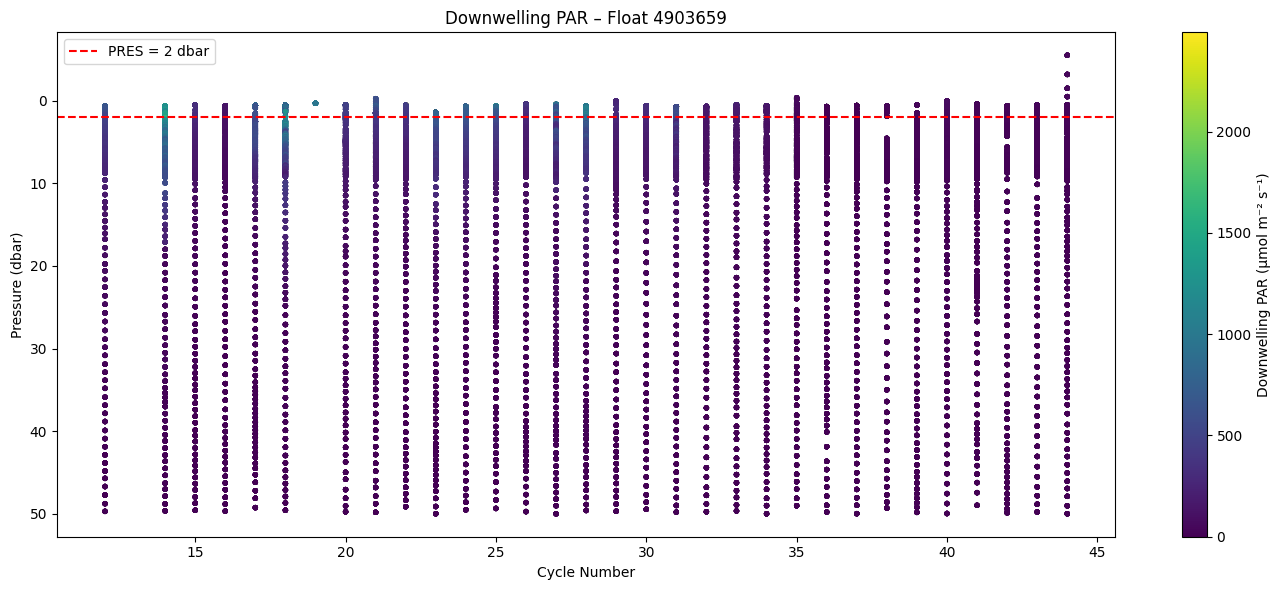

In [ ]:
# 4903659
# filtering first 100m
df_4903659 = df_4903659.filter(df_4903659["PRES_ADJUSTED"] <= 50)

plt.figure(figsize=(14, 6))

sc = plt.scatter(
    df_4903659["CYCLE_NUMBER"],
    df_4903659["PRES_ADJUSTED"],
    c=df_4903659["DOWNWELLING_PAR"],
    s=8,
    cmap="viridis",
)

plt.gca().invert_yaxis()  # depth increases downward
plt.colorbar(sc, label="Downwelling PAR (µmol m⁻² s⁻¹)")

# Horizontal line at PRES = 2
plt.axhline(2, color="red", linestyle="--", linewidth=1.5, label="PRES = 2 dbar")

plt.xlabel("Cycle Number")
plt.ylabel("Pressure (dbar)")
plt.title("Downwelling PAR – Float 4903659")
plt.legend()
plt.tight_layout()
plt.show()

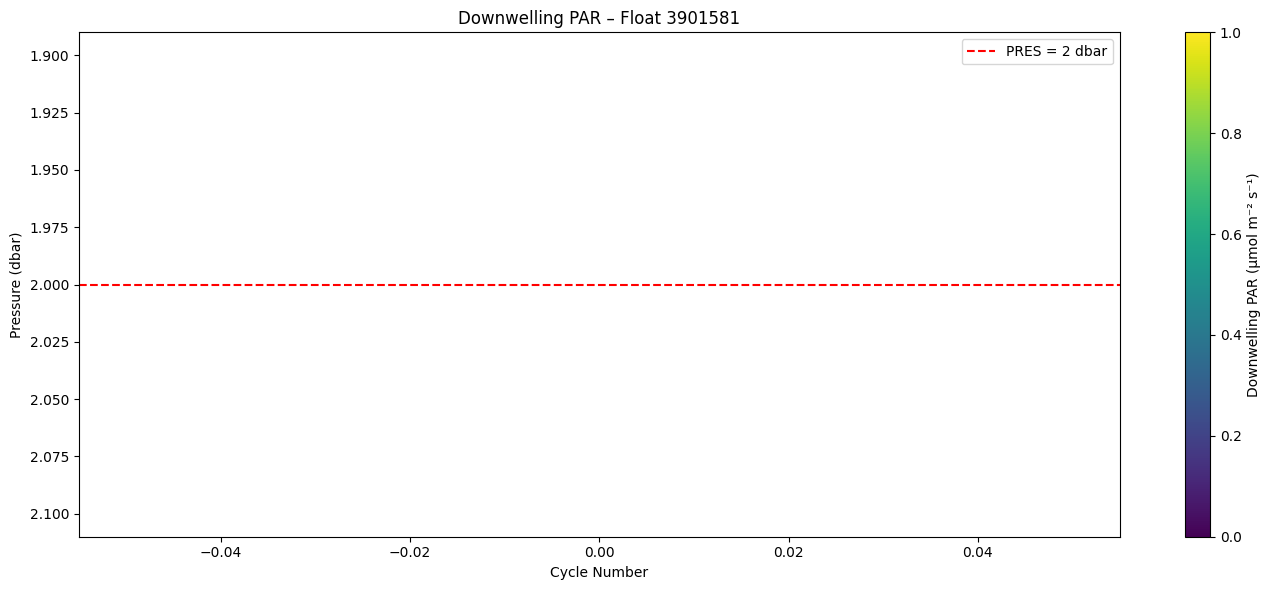

In [ ]:
# 3901581
# filtering first 100m
df_3901581 = df_3901581.filter(df_3901581["PRES_ADJUSTED"] <= 50)

plt.figure(figsize=(14, 6))

sc = plt.scatter(
    df_3901581["CYCLE_NUMBER"],
    df_3901581["PRES_ADJUSTED"],
    c=df_3901581["DOWNWELLING_PAR"],
    s=8,
    cmap="viridis",
)

plt.gca().invert_yaxis()  # depth increases downward
plt.colorbar(sc, label="Downwelling PAR (µmol m⁻² s⁻¹)")

# Horizontal line at PRES = 2
plt.axhline(2, color="red", linestyle="--", linewidth=1.5, label="PRES = 2 dbar")

plt.xlabel("Cycle Number")
plt.ylabel("Pressure (dbar)")
plt.title("Downwelling PAR – Float 3901581")
plt.legend()
plt.tight_layout()
plt.show()

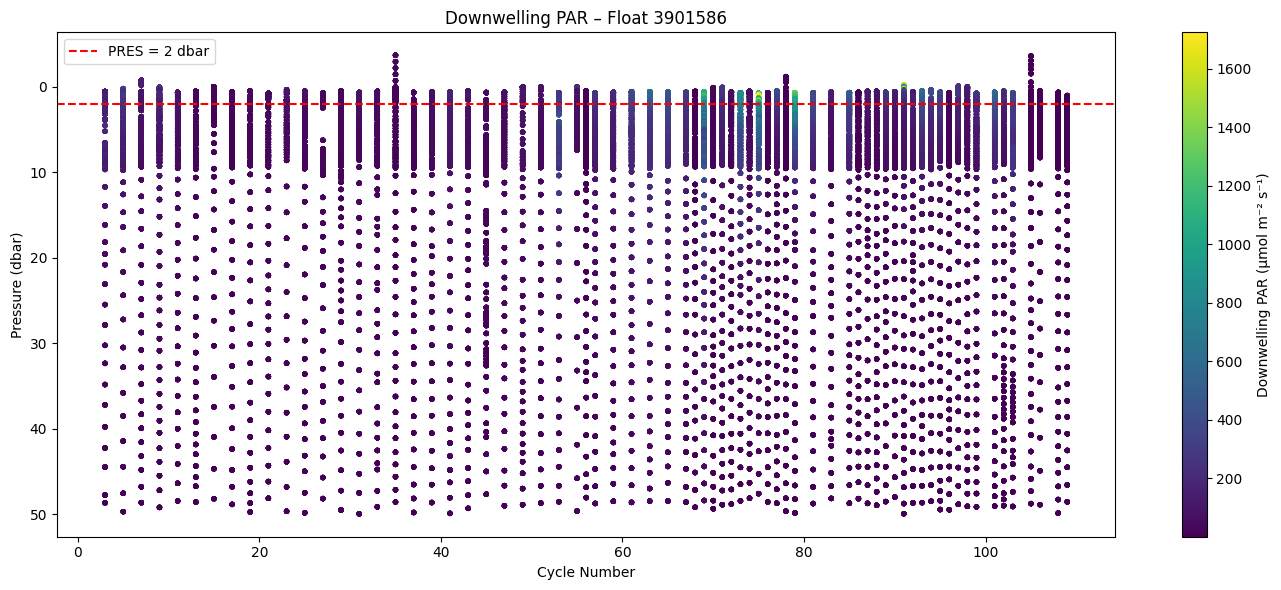

In [ ]:
# 3901586
# filtering first 100m
df_3901586 = df_3901586.filter(df_3901586["PRES_ADJUSTED"] <= 50)

plt.figure(figsize=(14, 6))

sc = plt.scatter(
    df_3901586["CYCLE_NUMBER"],
    df_3901586["PRES_ADJUSTED"],
    c=df_3901586["DOWNWELLING_PAR"],
    s=8,
    cmap="viridis",
)

plt.gca().invert_yaxis()  # depth increases downward
plt.colorbar(sc, label="Downwelling PAR (µmol m⁻² s⁻¹)")

# Horizontal line at PRES = 2
plt.axhline(2, color="red", linestyle="--", linewidth=1.5, label="PRES = 2 dbar")

plt.xlabel("Cycle Number")
plt.ylabel("Pressure (dbar)")
plt.title("Downwelling PAR – Float 3901586")
plt.legend()
plt.tight_layout()
plt.show()

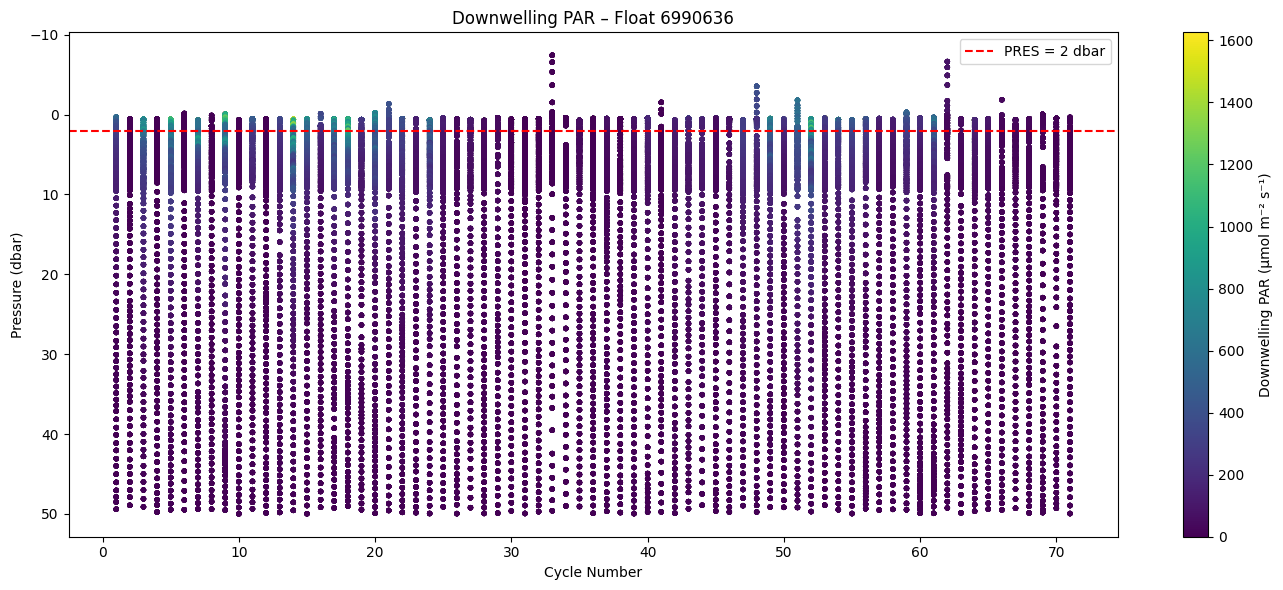

In [ ]:
#6990636
# filtering first 100m
df_6990636 = df_6990636.filter(df_6990636["PRES_ADJUSTED"] <= 50)

plt.figure(figsize=(14, 6))

sc = plt.scatter(
    df_6990636["CYCLE_NUMBER"],
    df_6990636["PRES_ADJUSTED"],
    c=df_6990636["DOWNWELLING_PAR"],
    s=8,
    cmap="viridis",
)

plt.gca().invert_yaxis()  # depth increases downward
plt.colorbar(sc, label="Downwelling PAR (µmol m⁻² s⁻¹)")

# Horizontal line at PRES = 2
plt.axhline(2, color="red", linestyle="--", linewidth=1.5, label="PRES = 2 dbar")

plt.xlabel("Cycle Number")
plt.ylabel("Pressure (dbar)")
plt.title("Downwelling PAR – Float 6990636")
plt.legend()
plt.tight_layout()
plt.show()

## Downloading Grouped Irradiance Dataset

# Downloading Handful of floats code

Downloading speific floats and estiamte physical parameters

## Downloading Floats 

In [ ]:
# Libraries for data handling

import polars as pl
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Library for estimating oceanographic parameters
import gsw

# Library for donwloading data

import os
from pathlib import Path
import argopy
from argopy import DataFetcher
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
import pandas as pd
xr.set_options(display_expand_attrs = False)

import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
)

In [ ]:
# Base filepath
root = '../data/argo/'
profile_dir = root + 'Profiles/'

# Create GO-BGC folders if they do not exist yet
if 'argo' not in os.listdir('../data/'):
  os.mkdir(root)
if 'Profiles' not in os.listdir(root):
  os.mkdir(profile_dir)

# Downloading data using argopy
float_ids = [4903659]  # Ice Shelf and Open Ocean Floats

# Fetching data
ds = DataFetcher(src ='gdac', 
                 mode = 'standard').float(
                     float_ids).to_xarray()

# Quality Control Filtering
ds = ds.argo.filter_qc(QC_list=[1,2])  # Keep only good and probably good data

# Downloading data using argopy

ds = ds.to_dataframe().reset_index()
ds = pl.from_pandas(ds)

# Saving in one dataset parquet
out_path = Path(profile_dir)/ f"Grouped_data_set.parquet"
out_path.parent.mkdir(parents=True, exist_ok=True)

ds.write_parquet(out_path)
print(f"Saved all float in one parquet -> {profile_dir}")

# Saving by Float number
#for fid in float_ids:
#    sub = ds.filter(pl.col("PLATFORM_NUMBER") == fid)
#    out_path = Path(profile_dir)/ f"{fid}.parquet"
#    out_path.parent.mkdir(parents=True, exist_ok=True)
#    sub.write_parquet(out_path)
#    print(f"Saved float {fid} -> {profile_dir}")


Saved all float in one parquet -> ../data/argo/Profiles/


## Comparing Basins

Creating Function:

1) density Calcl
2) Sigma0 Potential density
3) Estimating Mixlayer depth using the density threshold of ~0.3

In [ ]:
# Defining Function

"""
  In site density Calculation Function.
Using Gibbs SeaWater (GSW) Oceanographic Toolbox, it is added as 
another column to the Polars DataFrame.
"""
def add_density(df: pl.DataFrame) -> pl.DataFrame:
    # Extract numpy arrays
    SP  = df["PSAL"].to_numpy()
    t   = df["TEMP"].to_numpy()
    p   = df["PRES"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    # Compute absolute salinity, conservative temperature, density
    SA  = gsw.SA_from_SP(SP, p, lon, lat)
    CT  = gsw.CT_from_t(SA, t, p)
    rho = gsw.rho(SA, CT, p)

    # Append new column as a Polars Series
    return df.with_columns(pl.Series("RHO", rho))

# Creating potential density function (for MLD calculations)
def add_sigma0(df: pl.DataFrame) -> pl.DataFrame:
    """
    Add potential density anomaly sigma0 [kg/m^3 - 1000] as a column 'SIGMA0'.
    Requires PSAL [PSS-78], TEMP [°C in-situ], PRES [dbar], LONGITUDE [degE], LATITUDE [degN].
    """
    SP  = df["PSAL"].to_numpy()
    t   = df["TEMP"].to_numpy()
    p   = df["PRES"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)
    sigma0 = gsw.sigma0(SA, CT)  # kg/m^3 - 1000
    return df.with_columns(pl.Series("SIGMA0", sigma0))

# Creating Mixed Layer Depth function for MLD calculations
"""
 Calculation based on de Montety et al. (2014) definition:
"""
# Compute MLD per profile
def compute_mld_for_profile(pres: np.ndarray, sigma0: np.ndarray,
                            ref_depth: float = 10.0, drho_threshold: float = 0.03) -> float:
    sort_idx = np.argsort(pres)
    pres_sorted = pres[sort_idx]
    sigma0_sorted = sigma0[sort_idx]
    idx_ref = np.argmin(np.abs(pres_sorted - ref_depth))
    sigma0_ref = sigma0_sorted[idx_ref]
    sigma0_th = sigma0_ref + drho_threshold
    mask = sigma0_sorted >= sigma0_th
    mask[:(idx_ref+1)] = False
    if not np.any(mask):
        return np.nan
    idx_mld = np.where(mask)[0][0]
    return float(pres_sorted[idx_mld])





In [ ]:
# Loading data 
df = pl.read_parquet('../data/argo/profiles/Grouped_data_set.parquet')

# Filtering data below 500m
#df = df.filter(pl.col('PRES') < 500)

# Applying potential density Density calc Function
df = add_sigma0(df)

# Groupin and computing CHL per profile 
summary_mld = (
    df.group_by("PLATFORM_NUMBER", "CYCLE_NUMBER")
      .map_groups(lambda group: pl.DataFrame({
            "PLATFORM_NUMBER": [group["PLATFORM_NUMBER"].to_list()[0]],
            "CYCLE_NUMBER": [group["CYCLE_NUMBER"].to_list()[0]],
            "MLD": [
              compute_mld_for_profile(
                pres=group["PRES"].to_numpy(),
                sigma0=group["SIGMA0"].to_numpy(),
                ref_depth=10.0,
                drho_threshold=0.03
              )
            ]
        }))
)

# Joining MLD replicating to dataframe
df = df.join(summary_mld, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")

df.head()




N_POINTS,CYCLE_NUMBER,DATA_MODE,DIRECTION,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ERROR,PRES_QC,PSAL,PSAL_ERROR,PSAL_QC,TEMP,TEMP_ERROR,TEMP_QC,TIME_QC,TIME,LATITUDE,LONGITUDE,SIGMA0,MLD
i64,i64,str,str,i64,i64,f32,f32,i64,f32,f32,i64,f32,f32,i64,i64,datetime[ns],f64,f64,f64,f64
0,1,"""R""","""D""",4903659,1,1.5,null,1,35.139999,null,1,9.7295,null,1,1,2024-05-28 10:01:58,59.997924,-23.996627,27.110286,35.0
1,1,"""R""","""D""",4903659,1,2.5,null,1,35.148998,null,1,9.7314,null,1,1,2024-05-28 10:01:58,59.997924,-23.996627,27.117017,35.0
2,1,"""R""","""D""",4903659,1,3.6,null,1,35.154999,null,1,9.7228,null,1,1,2024-05-28 10:01:58,59.997924,-23.996627,27.123177,35.0
3,1,"""R""","""D""",4903659,1,4.5,null,1,35.153,null,1,9.7215,null,1,1,2024-05-28 10:01:58,59.997924,-23.996627,27.121851,35.0
4,1,"""R""","""D""",4903659,1,5.4,null,1,35.147999,null,1,9.7247,null,1,1,2024-05-28 10:01:58,59.997924,-23.996627,27.117422,35.0


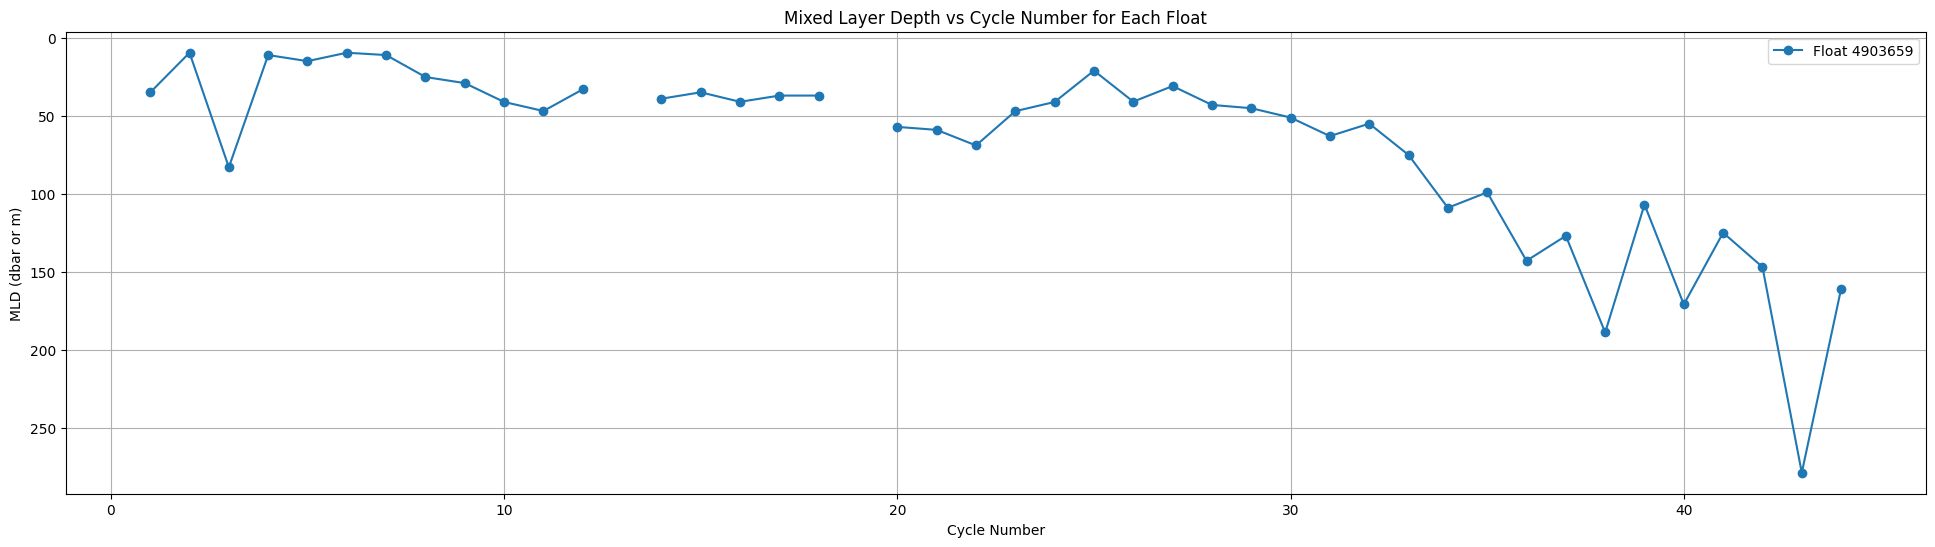

In [ ]:
# Plotting df

cycle_summary = (df.
                 select("PLATFORM_NUMBER", "CYCLE_NUMBER", "MLD")
                 .unique()
                 .sort("PLATFORM_NUMBER", "CYCLE_NUMBER"))

summary_pd = cycle_summary.to_pandas()


fig, ax = plt.subplots(figsize=(24,6))
for float_id, sub in summary_pd.groupby("PLATFORM_NUMBER"):
    ax.plot(sub["CYCLE_NUMBER"], sub["MLD"],
            marker="o", label=f"Float {float_id}")

ax.set_xlabel("Cycle Number")
ax.set_ylabel("MLD (dbar or m)")
ax.set_title("Mixed Layer Depth vs Cycle Number for Each Float")
ax.invert_yaxis()  # optional: deeper = larger depth, so invert if you want shallow at top
ax.legend()
plt.grid(True)
plt.show()

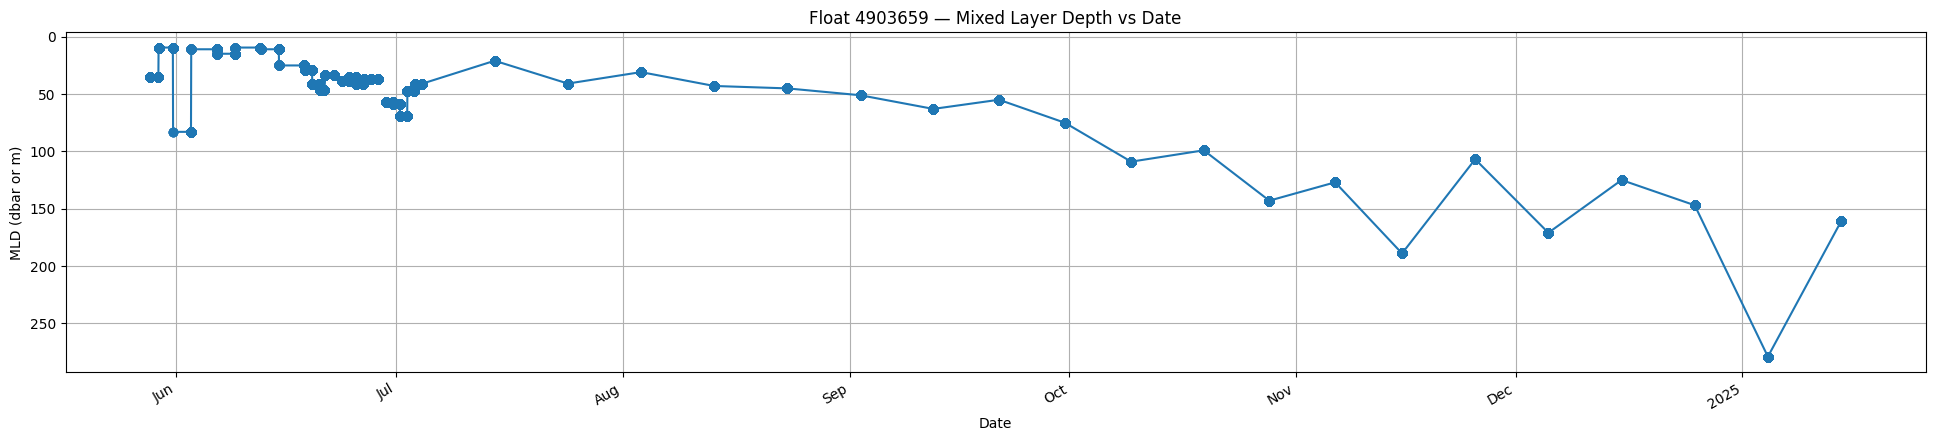

In [ ]:
pd_df = df.to_pandas()

# Make sure your date column is a proper datetime
# Example: if your column is 'JULD', convert like:
pd_df['TIME'] = pd.to_datetime(pd_df['TIME'])

# Filter by each float and plot
for fid in pd_df['PLATFORM_NUMBER'].unique():
    sub = pd_df[pd_df['PLATFORM_NUMBER'] == fid]
    # Summarise one MLD per cycle (assuming one MLD per cycle)
    summary = sub.groupby('CYCLE_NUMBER').agg({
        'TIME': 'first',   # or maybe 'min' or 'max' depending
        'MLD': 'first'
    }).reset_index()

    fig, ax = plt.subplots(figsize=(24,5))
    ax.plot(sub['TIME'], sub["MLD"],
            marker="o", label=f"Float {float_id}")
    ax.set_title(f"Float {fid} — Mixed Layer Depth vs Date")
    ax.set_xlabel("Date")
    ax.set_ylabel("MLD (dbar or m)")
    ax.invert_yaxis()  # deeper depth = larger number → put deeper downwards
    # Format the x-axis as dates
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    fig.autofmt_xdate()
    plt.grid(True)
    plt.show()

## Assesing Irradiance Problem

In [ ]:
# Plotting Irradiance profile by cycle






# Expanded Dataset
Analysis and parameters were developed based on studies Tanner et al. (2024) Shoeman, Erbe & McCauley 2024

# Download Expanded dataset
Here we download all profiles within region since 2014. Download are stored as Regional_Argo_Tablet.parquet. 

In [ ]:

from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

# Pacakages for data handling
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
import pandas as pd
import polars as pl
import os
from pathlib import Path
from shapely.geometry import Point, Polygon
xr.set_options(display_expand_attrs = False)

In [ ]:
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
)

### Define an ocean region to work with

For this demo notebook, we'll work with BGC floats in the Labrador Sea

For your own use, you can simply overwrite the ``BOX`` variable content with your region.

In [ ]:
# Format: [lon_min, lon_max, lat_min, lat_max, pres_min, pres_max, datim_min, datim_max]
BOX = [-44, -10, 55, 67, 0, 2000, '2012-08', '2026-01']

### Get more info about this region using the ArgoIndex

In [ ]:
# Load the BGC-synthetic profiles index
# rq: we work with synthetic profiles because that's the only dataset available from the erddap at this point (2023/07/21)
idx = ArgoIndex(index_file='bgc-s').load()  
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt.gz
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
In memory: True (368482 records)
Searched: False

In [ ]:
# Select profile in a space/time domain:
index_BOX = [BOX[ii] for ii in [0, 1, 2, 3, 6, 7]]  # We don't want the pressure axis BOX limits
idx = idx.query.box(index_BOX) # Had to replace this with something new as argopy has been updated

In [ ]:
# Get the list of all parameters for this region:
idx.read_params()

['BBP532',
 'BBP700',
 'BISULFIDE',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'DOXY_2',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [ ]:
# Extract the list of BGC parameters:
bgc_params = idx.read_params()
[bgc_params.remove(p) for p in ['PH_IN_SITU_TOTAL', 'BISULFIDE', 'CDOM', 'DOWN_IRRADIANCE380',
                                'DOWN_IRRADIANCE412','DOWN_IRRADIANCE490', 'DOXY','NITRATE',
                                'CP660','BBP700', 'CHLA_FLUORESCENCE', 'BBP532', 'DOXY_2']]  # Remove core variables from the list
bgc_params

['CHLA', 'DOWNWELLING_PAR', 'PRES', 'PSAL', 'TEMP']

In [ ]:
# How many different floats in the region:
len(idx.read_wmo())

129

### Loading Physical Data


In [ ]:
%%time

# f = DataFetcher(ds='bgc', mode='expert', params='all', parallel=True, progress=True).region(BOX).load()  # Fetch everything !
f = DataFetcher(ds='phy', mode='expert', params='all',
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )
f = f.region(BOX).load()
f

Final post-processing of the merged dataset ...
CPU times: user 8min 11s, sys: 1min 8s, total: 9min 19s
Wall time: 20min 50s


<datafetcher.erddap>
⭐ Name: Ifremer erddap Argo data fetcher for a space/time region
🗺  Domain: [x=-44.00/-10.00; y=55.00/67.00; z=0.0/2000.0; t=2012-08-01/2026-01-01]
🔗 API: https://erddap.ifremer.fr/erddap
🏄 User mode: expert
🟡+🔵 Dataset: phy
🌤  Performances: cache=False, parallel=True [thread]

In [ ]:
# Check the data structure (xarray.dataset):
ds = f.data
ds

<xarray.Dataset> Size: 11GB
Dimensions:                   (N_POINTS: 9273500)
Coordinates:
    LATITUDE                  (N_POINTS) float64 74MB 59.82 59.82 ... 58.54
    LONGITUDE                 (N_POINTS) float64 74MB -36.93 -36.93 ... -21.17
    TIME                      (N_POINTS) datetime64[ns] 74MB 2012-08-01T04:37...
  * N_POINTS                  (N_POINTS) int64 74MB 0 1 2 ... 9273498 9273499
Data variables: (12/23)
    CONFIG_MISSION_NUMBER     (N_POINTS) int64 74MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    CYCLE_NUMBER              (N_POINTS) int64 74MB 311 311 311 ... 220 220 220
    DATA_MODE                 (N_POINTS) <U1 37MB 'D' 'D' 'D' ... 'R' 'R' 'R'
    DIRECTION                 (N_POINTS) <U1 37MB 'A' 'A' 'A' ... 'A' 'A' 'A'
    PLATFORM_NUMBER           (N_POINTS) int64 74MB 4901404 4901404 ... 4902497
    POSITION_QC               (N_POINTS) int64 74MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    ...                        ...
    TEMP_ADJUSTED             (N_POINTS) float32 37MB 11.01 11.01 ... nan nan
    TEMP_ADJUSTED_ERROR       (N_POINTS) float32 37MB 0.002 0.002 ... nan nan
    TEMP_ADJUSTED_QC          (N_POINTS) int64 74MB 1 1 1 1 1 1 ... 0 0 0 0 0 0
    TEMP_QC                   (N_POINTS) int64 74MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    TIME_QC                   (N_POINTS) int64 74MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    VERTICAL_SAMPLING_SCHEME  (N_POINTS) <U246 9GB '' ... 'Primary sampling: ...
Attributes: (7)

In [ ]:
# Check the data through the argo xarray accessor:
ds.argo

<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(9273500) ~ N_PROF(31944) x N_LEVELS(3989)

Had to change directoy stuff


In [ ]:
# Create directories to save the data
rootdir = '../data/argo/'
paquet_dir = '../data/argo/Region/'

import os
if 'argo' not in os.listdir('../data/'):
    os.mkdir(rootdir)
if 'Region' not in os.listdir(rootdir):
    os.mkdir(paquet_dir)

df = pl.DataFrame(ds.to_dataframe()) # Here I can remove parameters if needed
df.write_parquet('../data/argo/Region/Regional_Argo_Tablet.parquet')

In [ ]:
# and check the corresponding index structure (pandas.dataframe):
df = f.index
df

,date,latitude,longitude,wmo,cyc
0,2023-07-03 15:05:00,59.562168,-38.311313,7901037,1
1,2023-07-04 16:25:00,59.757223,-40.911627,7901036,1
2,2025-04-02 01:34:00,66.989793,-24.404108,6990657,13
3,2024-06-28 12:57:59,60.078591,-20.071637,6990636,12
4,2024-06-25 00:47:22,60.153341,-21.595969,6990636,11
...,...,...,...,...,...
31939,2025-10-21 15:16:13,55.018770,-39.016880,7902325,10
31940,2025-11-21 10:23:41,55.118350,-39.832940,7902325,13
31941,2025-12-01 16:41:34,55.466330,-39.981070,7902325,14
31942,2025-12-11 22:54:03,55.877830,-39.602660,7902325,15


In [ ]:
df = pl.read_parquet('../data/argo/Region/Regional_Argo_Tablet.parquet')

df.head()

CONFIG_MISSION_NUMBER,CYCLE_NUMBER,DATA_MODE,DIRECTION,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_QC,TIME_QC,VERTICAL_SAMPLING_SCHEME,LATITUDE,LONGITUDE,TIME
i64,i64,str,str,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,i64,str,f64,f64,datetime[ns]
1,311,"""D""","""A""",4901404,1,2.5,2.5,2.4,1,1,34.861,34.860989,0.01,1,1,11.005,11.005,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14
1,311,"""D""","""A""",4901404,1,4.0,4.0,2.4,1,1,34.861,34.860958,0.01,1,1,11.005,11.005,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14
1,311,"""D""","""A""",4901404,1,6.0,6.0,2.4,1,1,34.861,34.861019,0.01,1,1,11.006,11.006,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14
1,311,"""D""","""A""",4901404,1,8.0,8.0,2.4,1,1,34.861,34.861382,0.01001,1,1,11.006,11.006,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14
1,311,"""D""","""A""",4901404,1,10.0,10.0,2.4,1,1,34.860001,34.860222,0.01,1,1,10.997,10.997,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14


### Loading BGC Data

In [ ]:
# Possible adjustments to box zone
BOX = [-44, -10, 55, 67, 0, 2000, '2010-08', '2025-01']

In [ ]:
%%time
# f = DataFetcher(ds='bgc', mode='expert', params='all', parallel=True, progress=True).region(BOX).load()  # Fetch everything !
f = DataFetcher(ds='bgc', mode='expert', params = 'all',
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )
f = f.region(BOX).load()
f

Final post-processing of the merged dataset ...
CPU times: user 50min 39s, sys: 4min 46s, total: 55min 26s
Wall time: 1h 12min 48s


<datafetcher.erddap>
⭐ Name: Ifremer erddap Argo BGC data fetcher for a space/time region
🗺  Domain: [x=-44.00/-10.00; y=55.00/67.00; z=0.0/2000.0; t=2010-08-01/2025-01-01]
🔗 API: https://erddap.ifremer.fr/erddap
📗 Parameters: ['BBP532', 'BBP700', 'BISULFIDE', 'CDOM', 'CHLA', 'CP660', 'DOWNWELLING_PAR', 'DOWN_IRRADIANCE380', 'DOWN_IRRADIANCE412', 'DOWN_IRRADIANCE490', 'DOXY', 'NITRATE', 'PH_IN_SITU_TOTAL', 'PRES', 'PSAL', 'TEMP']
📕 BGC 'must be measured' parameters: []
🏄 User mode: expert
🟢 Dataset: bgc-s
🌤  Performances: cache=False, parallel=True [thread]

In [ ]:
# Check the data structure (xarray.dataset):
ds = f.data
ds

<xarray.Dataset> Size: 4GB
Dimensions:                            (N_POINTS: 6370666)
Coordinates:
    LATITUDE                           (N_POINTS) float64 51MB 56.39 ... 61.2
    LONGITUDE                          (N_POINTS) float64 51MB -29.82 ... -15.85
    TIME                               (N_POINTS) datetime64[ns] 51MB 2010-08...
  * N_POINTS                           (N_POINTS) int64 51MB 0 1 ... 6370665
Data variables: (12/102)
    BBP532                             (N_POINTS) float32 25MB nan nan ... nan
    BBP532_ADJUSTED                    (N_POINTS) float32 25MB nan nan ... nan
    BBP532_ADJUSTED_ERROR              (N_POINTS) float32 25MB nan nan ... nan
    BBP532_ADJUSTED_QC                 (N_POINTS) int64 51MB 99999 ... 99999
    BBP532_DATA_MODE                   (N_POINTS) <U1 25MB '' '' '' ... '' '' ''
    BBP532_QC                          (N_POINTS) int64 51MB 99999 ... 99999
    ...                                 ...
    TEMP_ADJUSTED                      (N_POINTS) float32 25MB nan nan ... 3.563
    TEMP_ADJUSTED_ERROR                (N_POINTS) float32 25MB nan nan ... nan
    TEMP_ADJUSTED_QC                   (N_POINTS) int64 51MB 4 4 1 1 ... 8 8 1 8
    TEMP_DATA_MODE                     (N_POINTS) <U1 25MB 'D' 'D' ... 'R' 'R'
    TEMP_QC                            (N_POINTS) int64 51MB 3 1 1 1 ... 1 1 1 8
    TIME_QC                            (N_POINTS) int64 51MB 1 1 1 1 ... 1 1 1 1
Attributes: (7)

In [ ]:
# Check the data through the argo xarray accessor:
ds.argo

<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(6370666) ~ N_PROF(9059) x N_LEVELS(4694)

In [ ]:

df = pl.DataFrame(ds.to_dataframe()) 

Had to change directoy stuff


In [ ]:
# Create directories to save the data
rootdir = '../data/argo/'
paquet_dir = '../data/argo/Region/'

import os
if 'argo' not in os.listdir('../data/'):
    os.mkdir(rootdir)
if 'Region' not in os.listdir(rootdir):
    os.mkdir(paquet_dir)

df.write_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet.parquet')

In [ ]:
# and check the corresponding index structure (pandas.dataframe):
df = f.index
df

,file,date,latitude,longitude,ocean,profiler_code,institution_code,parameters,parameter_data_mode,date_update,wmo,cyc,institution,dac,profiler
0,aoml/1902304/profiles/SD1902304_157.nc,2024-03-21 21:21:39,55.297,-18.833,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,DDDAAAARAD,2025-12-22 18:43:02,1902304,157,"AOML, USA",aoml,NAVIS_EBR
1,aoml/1902304/profiles/SD1902304_158.nc,2024-03-31 21:31:53,55.727,-18.865,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,DDDAAAARAD,2025-12-22 18:43:12,1902304,158,"AOML, USA",aoml,NAVIS_EBR
2,aoml/1902304/profiles/SD1902304_159.nc,2024-04-10 21:11:20,56.325,-18.987,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,DDDAAAARAD,2025-12-22 18:43:22,1902304,159,"AOML, USA",aoml,NAVIS_EBR
3,aoml/1902304/profiles/SD1902304_160.nc,2024-04-20 21:24:52,56.290,-18.758,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,DDDAAAARAD,2025-12-22 18:43:32,1902304,160,"AOML, USA",aoml,NAVIS_EBR
4,aoml/1902304/profiles/SD1902304_161.nc,2024-04-30 21:30:20,56.509,-18.912,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,DDDAAAARAD,2025-12-22 18:43:42,1902304,161,"AOML, USA",aoml,NAVIS_EBR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9015,meds/4902580/profiles/SR4902580_056.nc,2023-11-28 17:19:00,55.490,-39.993,A,844,ME,PRES TEMP PSAL DOXY,RRRR,2025-08-28 14:26:57,4902580,56,"MEDS, Canada",meds,ARVOR float with SBE conductivity sensor
9016,meds/4902580/profiles/SR4902580_057.nc,2023-12-08 22:14:00,55.595,-39.787,A,844,ME,PRES TEMP PSAL DOXY,RRRR,2025-08-28 14:27:08,4902580,57,"MEDS, Canada",meds,ARVOR float with SBE conductivity sensor
9017,meds/4902580/profiles/SR4902580_058.nc,2023-12-19 03:17:00,55.784,-39.845,A,844,ME,PRES TEMP PSAL DOXY,RRRR,2025-08-28 14:27:21,4902580,58,"MEDS, Canada",meds,ARVOR float with SBE conductivity sensor
9018,meds/4902580/profiles/SR4902580_059.nc,2023-12-29 08:11:00,55.797,-38.772,A,844,ME,PRES TEMP PSAL DOXY,RRRR,2025-08-28 14:27:32,4902580,59,"MEDS, Canada",meds,ARVOR float with SBE conductivity sensor


### Tagging By Float By Region

Creating polygons to produce a polygone mask to seperate dataset

In [ ]:
df = pl.read_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet.parquet')

df.head()

BBP532,BBP532_ADJUSTED,BBP532_ADJUSTED_ERROR,BBP532_ADJUSTED_QC,BBP532_DATA_MODE,BBP532_QC,BBP700,BBP700_ADJUSTED,BBP700_ADJUSTED_ERROR,BBP700_ADJUSTED_QC,BBP700_DATA_MODE,BBP700_QC,BISULFIDE,BISULFIDE_ADJUSTED,BISULFIDE_ADJUSTED_ERROR,BISULFIDE_ADJUSTED_QC,BISULFIDE_DATA_MODE,BISULFIDE_QC,CDOM,CDOM_ADJUSTED,CDOM_ADJUSTED_ERROR,CDOM_ADJUSTED_QC,CDOM_DATA_MODE,CDOM_QC,CHLA,CHLA_ADJUSTED,CHLA_ADJUSTED_ERROR,CHLA_ADJUSTED_QC,CHLA_DATA_MODE,CHLA_QC,CONFIG_MISSION_NUMBER,CP660,CP660_ADJUSTED,CP660_ADJUSTED_ERROR,CP660_ADJUSTED_QC,CP660_DATA_MODE,CP660_QC,…,DOXY_QC,NITRATE,NITRATE_ADJUSTED,NITRATE_ADJUSTED_ERROR,NITRATE_ADJUSTED_QC,NITRATE_DATA_MODE,NITRATE_QC,PH_IN_SITU_TOTAL,PH_IN_SITU_TOTAL_ADJUSTED,PH_IN_SITU_TOTAL_ADJUSTED_ERROR,PH_IN_SITU_TOTAL_ADJUSTED_QC,PH_IN_SITU_TOTAL_DATA_MODE,PH_IN_SITU_TOTAL_QC,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_DATA_MODE,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_DATA_MODE,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_DATA_MODE,TEMP_QC,TIME_QC,LATITUDE,LONGITUDE,TIME
f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f32,f32,f32,i64,str,i64,…,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f64,f64,datetime[ns]
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,0.0,0.0,2.4,1,"""D""",1,34.801998,null,null,4,"""D""",3,12.661,null,null,4,"""D""",3,1,56.387,-29.825,2010-08-05 04:35:00
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,6.0,6.0,2.4,1,"""D""",1,34.806999,null,null,4,"""D""",3,12.664,null,null,4,"""D""",1,1,56.387,-29.825,2010-08-05 04:35:00
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,17.0,17.0,2.4,1,"""D""",1,34.806999,34.806999,0.01,1,"""D""",1,12.666,12.666,0.002,1,"""D""",1,1,56.387,-29.825,2010-08-05 04:35:00
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,26.0,26.0,2.4,1,"""D""",1,34.807999,34.807999,0.01,1,"""D""",1,12.662,12.662,0.002,1,"""D""",1,1,56.387,-29.825,2010-08-05 04:35:00
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,36.0,36.0,2.4,1,"""D""",1,34.814999,34.814999,0.01,1,"""D""",1,12.633,12.633,0.002,1,"""D""",1,1,56.387,-29.825,2010-08-05 04:35:00


In [ ]:
# -*- coding: utf-8 -*-
"""
Apply two custom geographic regions to parquet datasets using exact polygons.
Adds a 'region' column with values:
    'irminger', 'icelandic', or 'Other'
"""

from pathlib import Path
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon


# -------------------------------------------------------
# REGION POLYGONS (EXACT SHAPES)
# -------------------------------------------------------

irminger_vertices = [
    (-44, 66),
    (-24, 66),
    (-24, 64),
    (-35, 55),
    (-44, 55)
]
irminger_poly = Polygon(irminger_vertices)

# Vertices in (lon, lat) order
icelandic_vertices = [
    (-24, 64),   # 1
    (-10, 64),   # 2
    (-20, 55),   # 3
    (-35, 55)   # 4
]
icelandic_poly = Polygon(icelandic_vertices)


# -------------------------------------------------------
# GLOBAL CONFIG
# -------------------------------------------------------

USE_DEEP_OCEAN_MASK = False
ETOPO1_PATH = Path("../data/etopo1_subset.nc")

PARQUETS = [
    Path("../data/argo/Region/Regional_Argo_Tablet.parquet"),
    Path("../data/argo/Region/Regional_BGC-Argo_Tablet.parquet")
    #,Path("../data/argo/Profiles/argo_sprof_flat_pd.parquet")
]

COL_LON = "LONGITUDE"
COL_LAT = "LATITUDE"

OVERLAP_PRECEDENCE = "shape2_over_shape1"   # icelandic overrides irminger


# -------------------------------------------------------
# HELPERS
# -------------------------------------------------------

def to_minus180_180(lon):
    lon = np.asarray(lon, dtype=float)
    return ((lon + 180.0) % 360.0) - 180.0


def load_etopo(path):
    import xarray as xr
    if not path.exists():
        print(f"[WARN] ETOPO file not found at {path}. Deep-ocean mask skipped.")
        return None
    ds = xr.open_dataset(path)
    for k in ("z", "longitude", "latitude"):
        if k not in ds:
            raise ValueError("ETOPO dataset must include variables: z, longitude, latitude")
    return ds


def deep_mask_from_etopo(ds, lonp, latp, thresh=-1000.0):
    zi = ds["z"].interp(longitude=(["p"], lonp), latitude=(["p"], latp)).values
    return zi <= float(thresh)


# -------------------------------------------------------
# POLYGON-BASED SHAPE CLASSIFICATION
# -------------------------------------------------------

def classify_shapes(lonp, latp):
    points = [Point(lonp[i], latp[i]) for i in range(len(lonp))]

    in_irminger  = np.array([irminger_poly.contains(pt) for pt in points])
    in_icelandic = np.array([icelandic_poly.contains(pt) for pt in points])

    debug = {
        "irminger_vertices": irminger_vertices,
        "icelandic_vertices": icelandic_vertices,
        "irminger_count": int(in_irminger.sum()),
        "icelandic_count": int(in_icelandic.sum()),
    }

    return in_irminger, in_icelandic, debug


# -------------------------------------------------------
# LABEL ASSIGNMENT (IRINGER / ICELANDIC / OTHER)
# -------------------------------------------------------

def assign_labels(in1, in2, precedence="icelandic_over_irminger"):
    labels = np.full(len(in1), "Other", dtype=object)

    if precedence == "icelandic_over_irminger":
        labels[in1] = "irminger"
        labels[in2] = "icelandic"    # overrides overlaps
    else:
        labels[in2] = "icelandic"
        labels[in1] = "irminger"

    return labels


# -------------------------------------------------------
# PROCESS ONE PARQUET
# -------------------------------------------------------

def process_one(parquet_path, ds_etopo=None, use_deep=False):
    print(f"\n======== Processing: {parquet_path.name} ========")

    if not parquet_path.exists():
        print(f"[WARN] Missing parquet: {parquet_path} (skipped)")
        return

    df = pd.read_parquet(parquet_path).copy()

    if COL_LON not in df or COL_LAT not in df:
        raise KeyError(f"Expected columns '{COL_LON}' and '{COL_LAT}' in {parquet_path}")

    LON_raw = df[COL_LON].astype(float).to_numpy()
    LAT     = df[COL_LAT].astype(float).to_numpy()
    LON     = to_minus180_180(LON_raw)

    print(f"Lon raw range: {np.nanmin(LON_raw):.3f} → {np.nanmax(LON_raw):.3f}")
    print(f"Lon norm range: {np.nanmin(LON):.3f} → {np.nanmax(LON):.3f}")
    print(f"Lat range:      {np.nanmin(LAT):.3f} → {np.nanmax(LAT):.3f}")
    print(f"N rows:         {len(df)}")

    # Polygon classification
    in_irminger, in_icelandic, dbg = classify_shapes(LON, LAT)

    print("\n-- Irminger region --")
    print("Vertices:", dbg["irminger_vertices"])
    print("Points in region:", dbg["irminger_count"])

    print("\n-- Icelandic region --")
    print("Vertices:", dbg["icelandic_vertices"])
    print("Points in region:", dbg["icelandic_count"])

    # Deep-ocean mask
    if use_deep:
        if ds_etopo is None:
            raise RuntimeError("USE_DEEP_OCEAN_MASK=True but no ETOPO dataset loaded.")
        deep = deep_mask_from_etopo(ds_etopo, LON, LAT, thresh=-1000.0)
        in_irminger &= deep
        in_icelandic &= deep

    # Assign region names
    labels = assign_labels(in_irminger, in_icelandic, precedence=OVERLAP_PRECEDENCE)
    df["region"] = labels

    # Save result
    df.to_parquet(parquet_path, index=False)
    print("\nWrote:", parquet_path)
    print("Region counts:\n", df["region"].value_counts(dropna=False).to_string())


# -------------------------------------------------------
# MAIN
# -------------------------------------------------------

def main():
    ds = load_etopo(ETOPO1_PATH) if USE_DEEP_OCEAN_MASK else None
    for pq in PARQUETS:
        process_one(pq, ds_etopo=ds, use_deep=USE_DEEP_OCEAN_MASK)

if __name__ == "__main__":
    main()


======== Processing: Regional_Argo_Tablet.parquet ========
Lon raw range: -44.000 → -10.002
Lon norm range: -44.000 → -10.002
Lat range:      55.001 → 66.999
N rows:         9273500

-- Irminger region --
Vertices: [(-44, 66), (-24, 66), (-24, 64), (-35, 55), (-44, 55)]
Points in region: 5317003

-- Icelandic region --
Vertices: [(-24, 64), (-10, 64), (-20, 55), (-35, 55)]
Points in region: 3243074

Wrote: ../data/argo/Region/Regional_Argo_Tablet.parquet
Region counts:
 region
irminger     5317003
icelandic    3243074
Other         713423

======== Processing: Regional_BGC-Argo_Tablet.parquet ========
Lon raw range: -43.995 → -10.004
Lon norm range: -43.995 → -10.004
Lat range:      55.003 → 66.981
N rows:         6370666

-- Irminger region --
Vertices: [(-44, 66), (-24, 66), (-24, 64), (-35, 55), (-44, 55)]
Points in region: 3903894

-- Icelandic region --
Vertices: [(-24, 64), (-10, 64), (-20, 55), (-35, 55)]
Points in region: 2331954

Wrote: ../data/argo/Region/Regional_BGC-Argo_T


===== Regional_Argo_Tablet.parquet =====
TIME range: 2012-08-01 04:37:14 → 2025-12-31 20:40:00


,region,year,month,profile_count
0,Other,2012,8,16
1,Other,2012,9,23
2,Other,2012,10,19
3,Other,2012,11,12
4,Other,2012,12,21
5,Other,2013,1,19
6,Other,2013,2,13
7,Other,2013,3,7
8,Other,2013,4,7
9,Other,2013,5,8


,region,year,week,profile_count
0,Other,2012,31,3
1,Other,2012,32,2
2,Other,2012,33,5
3,Other,2012,34,4
4,Other,2012,35,4
5,Other,2012,36,5
6,Other,2012,37,4
7,Other,2012,38,5
8,Other,2012,39,7
9,Other,2012,40,6


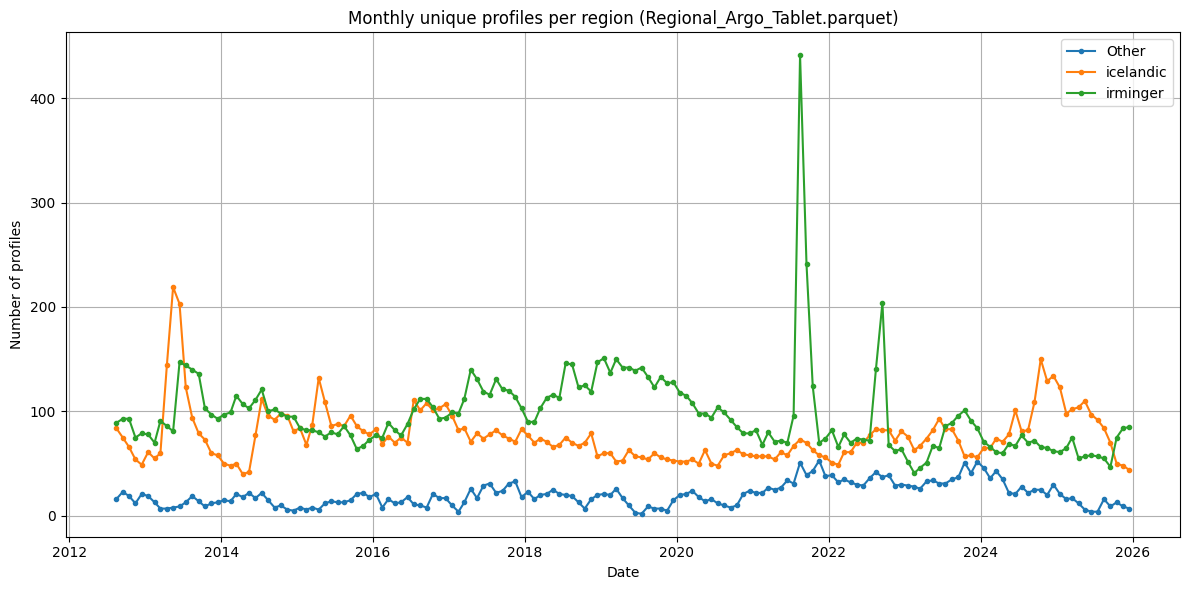

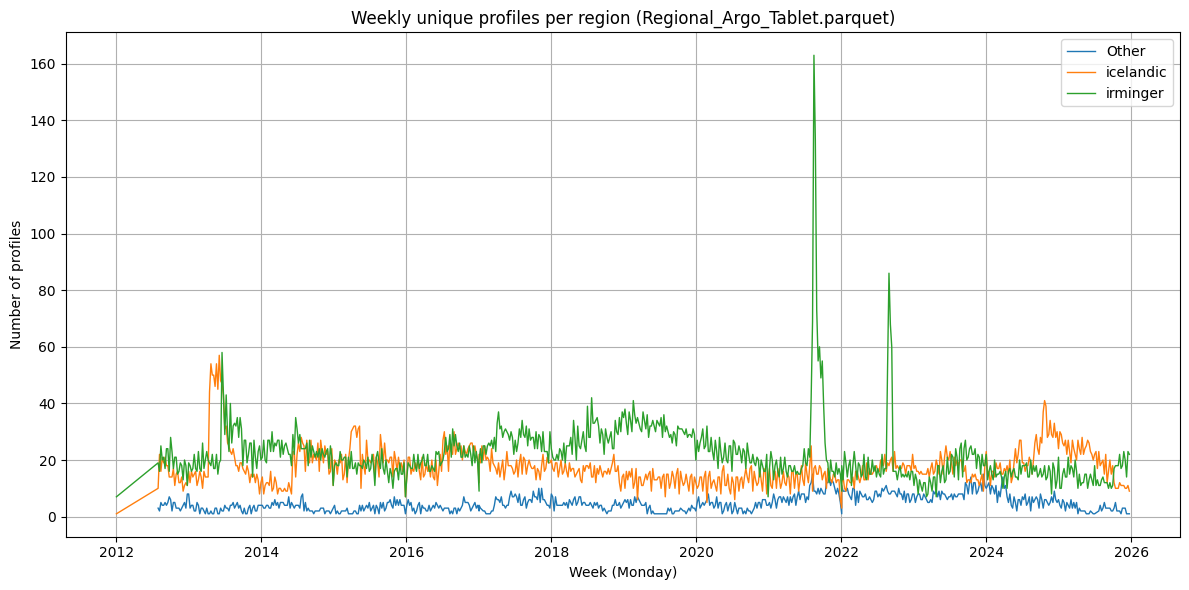

<Figure size 1200x600 with 0 Axes>

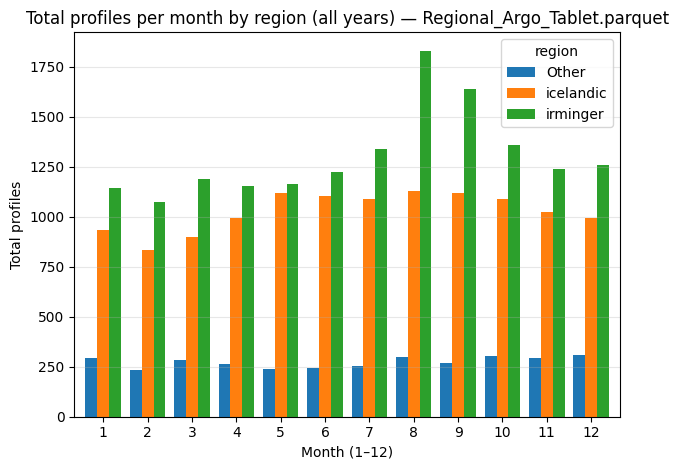

<Figure size 1200x600 with 0 Axes>

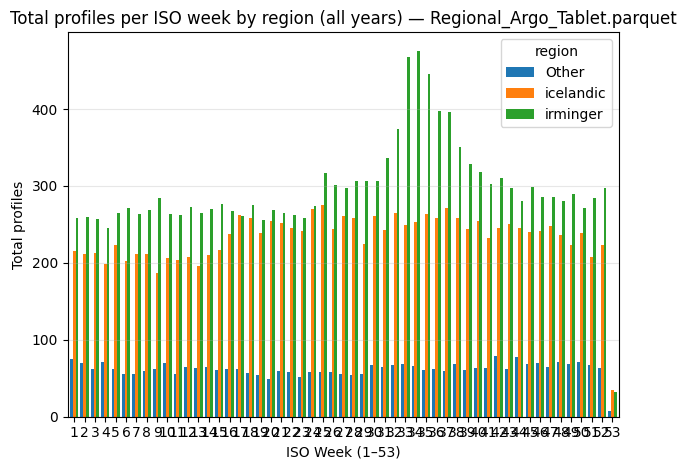


===== Regional_BGC-Argo_Tablet.parquet =====
TIME range: 2010-08-05 04:35:00 → 2024-12-31 13:13:14.012000


,region,year,month,profile_count
0,Other,2013,3,2
1,Other,2013,5,1
2,Other,2013,6,4
3,Other,2013,7,4
4,Other,2013,8,2
5,Other,2013,9,3
6,Other,2013,10,1
7,Other,2013,11,3
8,Other,2013,12,3
9,Other,2014,1,2


,region,year,week,profile_count
0,Other,2013,10,1
1,Other,2013,11,1
2,Other,2013,20,1
3,Other,2013,22,1
4,Other,2013,24,1
5,Other,2013,25,1
6,Other,2013,26,1
7,Other,2013,27,1
8,Other,2013,28,1
9,Other,2013,29,1


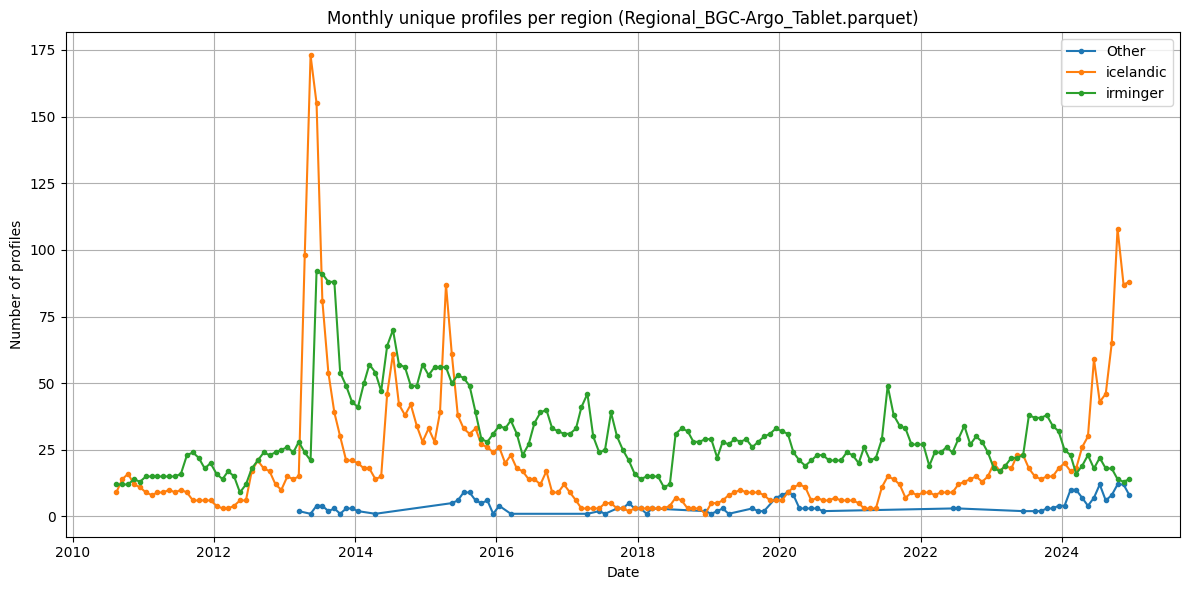

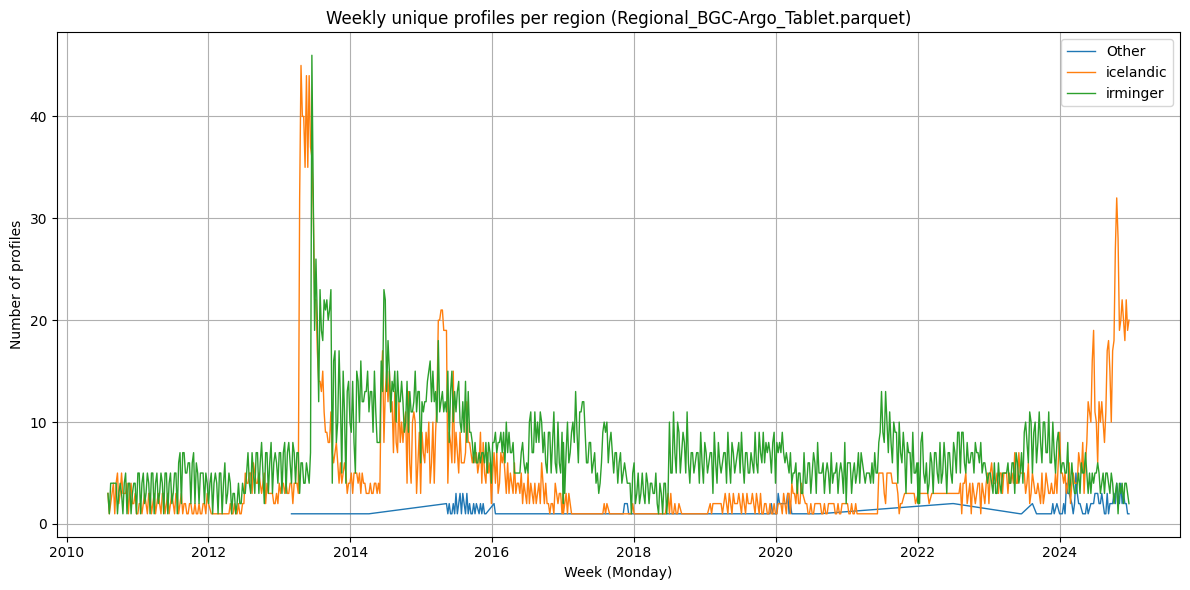

<Figure size 1200x600 with 0 Axes>

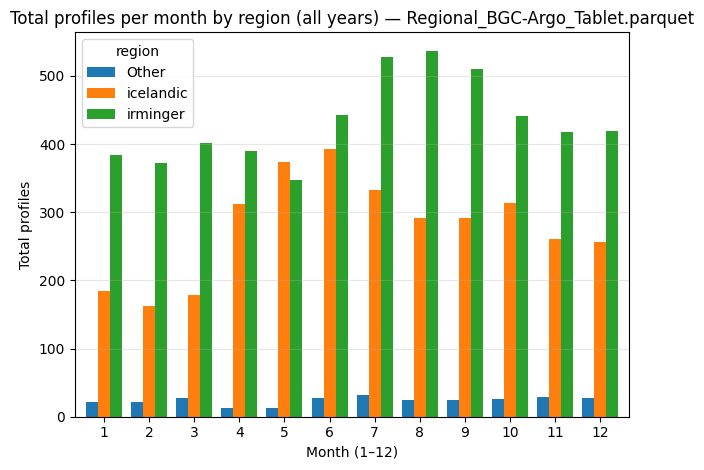

<Figure size 1200x600 with 0 Axes>

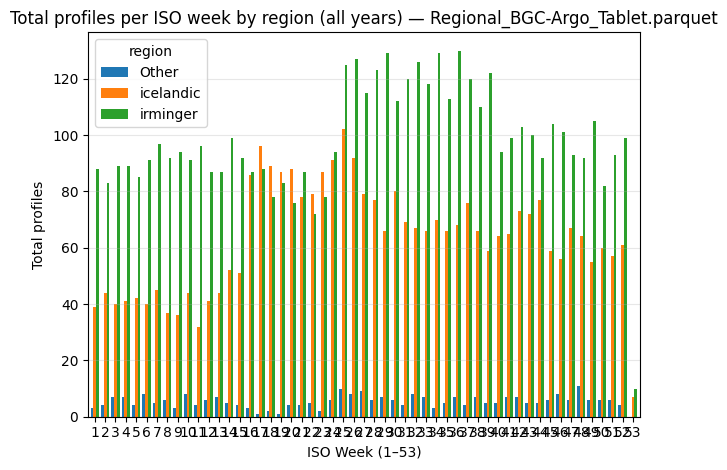

In [ ]:
# --- Quick check: number of unique profiles per region for BOTH datasets ---

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Files to analyze
parquets = [
    Path("../data/argo/Region/Regional_Argo_Tablet.parquet"),
    Path("../data/argo/Region/Regional_BGC-Argo_Tablet.parquet")
    #,Path("../data/argo/Profiles/argo_sprof_flat_pd.parquet")
]

# Columns (adjust if needed)
COL_TIME = "TIME"
COL_PLATFORM = "PLATFORM_NUMBER"
COL_CYCLE = "CYCLE_NUMBER"
COL_REGION = "region"

for parquet_path in parquets:
    print(f"\n===== {parquet_path.name} =====")
    df = pd.read_parquet(parquet_path)

    # --- Parse datetime ---
    df[COL_TIME] = pd.to_datetime(df[COL_TIME], errors="coerce", utc=True).dt.tz_convert(None)
    print("TIME range:", df[COL_TIME].min(), "→", df[COL_TIME].max())

    # --- Each (platform, cycle, region) = one profile ---
    profiles = df.drop_duplicates(subset=[COL_PLATFORM, COL_CYCLE, COL_REGION]).copy()

    # --- Extract year / month / ISO week ---
    profiles["year"] = profiles[COL_TIME].dt.year
    profiles["month"] = profiles[COL_TIME].dt.month
    profiles["week"] = profiles[COL_TIME].dt.isocalendar().week.astype(int)

    # --- Count profiles per region ---
    monthly_counts = (
        profiles.groupby(["region", "year", "month"], dropna=False)
        .size()
        .reset_index(name="profile_count")
        .sort_values(["region", "year", "month"])
    )

    weekly_counts = (
        profiles.groupby(["region", "year", "week"], dropna=False)
        .size()
        .reset_index(name="profile_count")
        .sort_values(["region", "year", "week"])
    )

    display(monthly_counts.head(10))
    display(weekly_counts.head(10))

    # --- Monthly plot ---
    plt.figure(figsize=(12, 6))
    for region, group in monthly_counts.groupby("region", dropna=False):
        # Plot at mid-month
        dates = pd.to_datetime(group["year"].astype(str) + "-" + group["month"].astype(str) + "-15")
        label = "NaN" if pd.isna(region) else region
        plt.plot(dates, group["profile_count"], marker="o", ms=3, label=label)
    plt.title(f"Monthly unique profiles per region ({parquet_path.name})")
    plt.xlabel("Date")
    plt.ylabel("Number of profiles")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Weekly plot ---
    plt.figure(figsize=(12, 6))
    for region, group in weekly_counts.groupby("region", dropna=False):
        # Monday of the ISO week
        dates = pd.to_datetime(
            group["year"].astype(str) + "-W" + group["week"].astype(str) + "-1",
            format="%G-W%V-%u",
        )
        label = "NaN" if pd.isna(region) else region
        plt.plot(dates, group["profile_count"], linewidth=1, label=label)
    plt.title(f"Weekly unique profiles per region ({parquet_path.name})")
    plt.xlabel("Week (Monday)")
    plt.ylabel("Number of profiles")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()   
    
     # --- Total profiles per calendar month, broken down by region ---
    monthly_region_totals = (
        monthly_counts
        .groupby(["region", "month"])["profile_count"]
        .sum()
        .reset_index()
        .pivot(index="month", columns="region", values="profile_count")
        .fillna(0)
        .sort_index()
    )

    plt.figure(figsize=(12, 6))
    monthly_region_totals.plot(kind="bar", width=0.8)
    plt.title(f"Total profiles per month by region (all years) — {parquet_path.name}")
    plt.xlabel("Month (1–12)")
    plt.ylabel("Total profiles")
    plt.xticks(rotation=0)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

        # --- Total profiles per ISO week, broken down by region ---
    weekly_region_totals = (
        weekly_counts
        .groupby(["region", "week"])["profile_count"]
        .sum()
        .reset_index()
        .pivot(index="week", columns="region", values="profile_count")
        .fillna(0)
        .sort_index()
    )

    plt.figure(figsize=(12, 6))
    weekly_region_totals.plot(kind="bar", width=0.8)
    plt.title(f"Total profiles per ISO week by region (all years) — {parquet_path.name}")
    plt.xlabel("ISO Week (1–53)")
    plt.ylabel("Total profiles")
    plt.xticks(rotation=0)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


Plotting positions for: Regional_Argo_Tablet.parquet


/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:483: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().get_tightbbox(renderer, *args, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packag

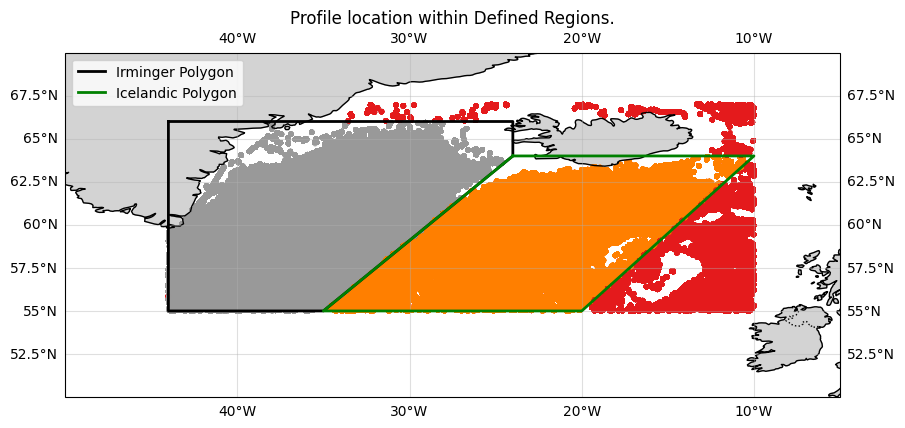


Plotting positions for: Regional_BGC-Argo_Tablet.parquet


/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:483: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().get_tightbbox(renderer, *args, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packag

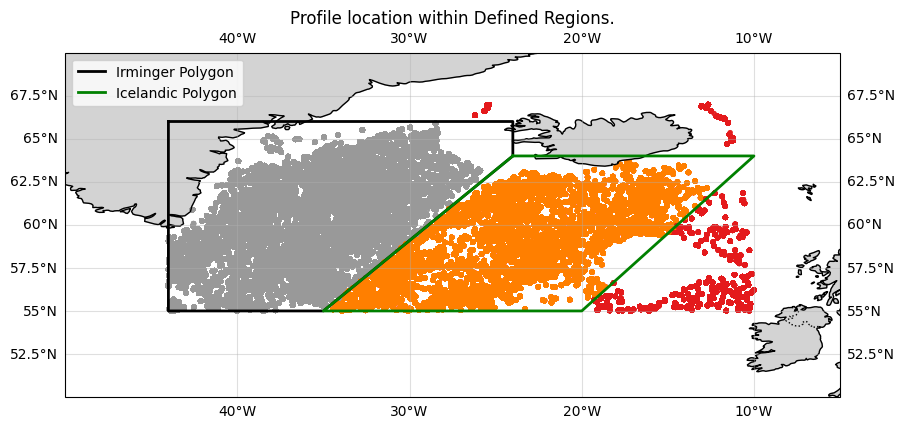

In [ ]:
# Plotting the location of the floats
# -------------------------------------------------------
# PLOT PROFILE LOCATIONS WITH REGION POLYGONS
# -------------------------------------------------------

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Reload DataFrame (already includes region labels)
for parquet_path in parquets:
    print(f"\nPlotting positions for: {parquet_path.name}")
    df = pd.read_parquet(parquet_path)

    # Normalise longitude
    lon = ((df["LONGITUDE"] + 180) % 360) - 180
    lat = df["LATITUDE"]

    # Setup figure
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Map extent (adjust if needed)
    ax.set_extent([-50, -5, 50, 70], crs=ccrs.PlateCarree())

    # Add base features
    ax.add_feature(cfeature.LAND, color="lightgray")
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.gridlines(draw_labels=True, alpha=0.4)

    # --- Plot the profile points ---
    scatter = ax.scatter(
        lon,
        lat,
        c=df["region"].astype("category").cat.codes,
        s=8,
        alpha=0.7,
        cmap="Set1",
        transform=ccrs.PlateCarree(),
    )

    # --- Plot the two polygons (region boundaries) ---
    irm_lons, irm_lats = zip(*irminger_vertices)
    ax.plot(irm_lons + (irm_lons[0],),
            irm_lats + (irm_lats[0],),
            "-k", lw=2, label="Irminger Polygon")

    ice_lons, ice_lats = zip(*icelandic_vertices)
    ax.plot(ice_lons + (ice_lons[0],),
            ice_lats + (ice_lats[0],),
            "-g", lw=2, label="Icelandic Polygon")

    # --- Legend ---
    plt.title(f"Profile location within Defined Regions.")
    plt.legend()
    plt.show()